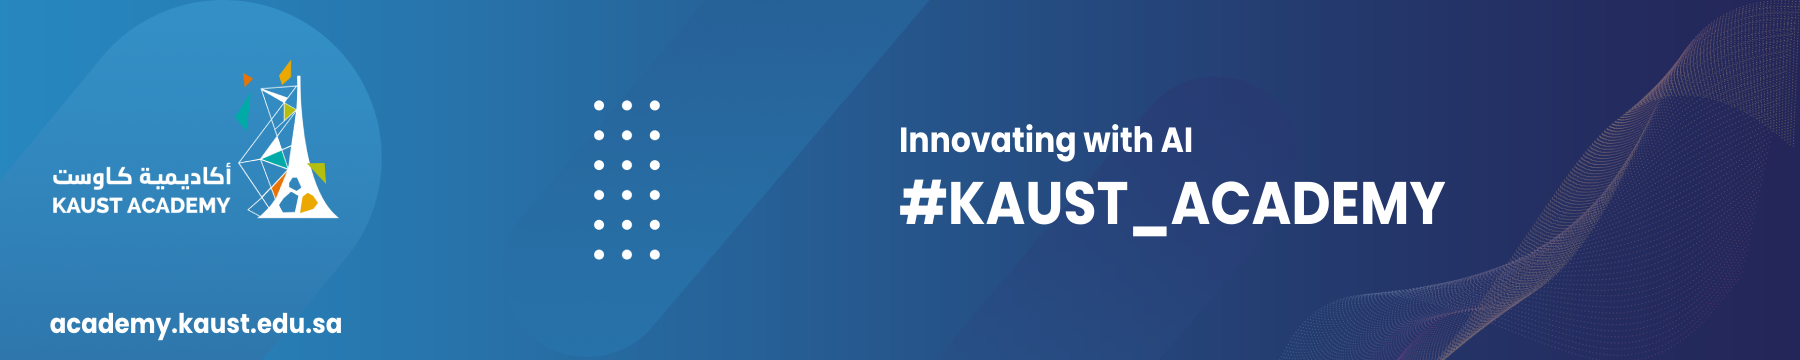

This notebook is inspired from [rl-notes's article](https://gibberblot.github.io/rl-notes/single-agent/multi-armed-bandits.html), written by Tim Miller

# Contents

In this notebook, we will look at the concept of exploration vs exploitation using the "Multi Arm Bandit" problem

## Context

![Bandit Image](https://gibberblot.github.io/rl-notes/_images/multi-armed-bandit.png)

Imagine that you have N number of slot machines (or poker machines in Australia), which are sometimes called one-armed bandits, due to the “arm” on the side that people pull to run again. Over time, each bandit pays a random reward from an unknown probability distribution. Some bandits are morely likely to get a winning payoff than others – we just do not know which ones at the start. The goal is to maximize the total rewards of a sequence of lever pulls of the machine.

## Multi-armed bandit problem

A multi-armed bandit (also known as an
N-armed bandit) is defined by a set of random variables
 where:

$1 \leq i \leq N$, such that
 is the arm of the bandit; and

 $k$ the index of the play of arm
;

Successive plays are assumed to be independently distributed, but we do not know the probability distributions of the random variables.

The idea is that a gambler iteratively plays rounds, observing the reward from the arm after each round, and can adjust their strategy each time. The aim is to maximise the sum of the rewards collected over all rounds.

Multi-arm bandit strategies aim to learn a policy $\pi(k)$, where $k$
 is the play.

# Approach

We will create a simple Q-Table based policy and optimize it for the problem.
We will run our approach over a set of different values of exploration parameter(epsilon) and see how the different runs compare with each other

Epsilon is a hyper parameter which controls how much exploration we can do.
epsilon ranges from 0 to 1 where 0 is no exploration and 1 only exploration(all actions are randomly selected)

In this notebook we will only implement the "EpsilonGreedy" strategy. There are some other approaches out there like epsilon-decreasing(one of the most popular ones) and Softmax-strategy

In [ ]:
from collections import defaultdict
import random
import json
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Simple class to represent the QTable
class QTable():
    def __init__(self, alpha=0.1, default_q_value=0.0):
        self.qtable = defaultdict(lambda: default_q_value)
        self.alpha = alpha

    def update(self, state, action, delta):
        self.qtable[(state, action)] = self.qtable[(state, action)] + self.alpha * delta

    def get_q_value(self, state, action):
        return self.qtable[(state, action)]

    def get_best_action(self, state, actions):
        q_vals = [self.get_q_value(state, action) for action in actions]
        return actions[q_vals.index(max(q_vals))]


# Base class for bandit with our strategy. We will extend this to create a class representing our strategy
class MultiArmedBandit():

    """ Select an action for this state given from a list given a Q-function """
    def select(self, state, actions, qfunction):
        pass

    """ Reset a multi-armed bandit to its initial configuration """

    def reset(self):
        self.__init__()


""" Run a bandit algorithm for a number of episodes, with each episode
being a set length.
"""
def run_bandit(bandit, episodes=200, episode_length=500, drift=True):

    # The actions available
    actions = [0, 1, 2, 3, 4]

    # A dummy state
    state = 1

    rewards = []
    for _ in range(0, episodes):
        bandit.reset()

        # The probability of receiving a payoff of 1 for each action
        probabilities = [0.1, 0.3, 0.7, 0.2, 0.1]

        # The number of times each arm has been selected
        times_selected = defaultdict(lambda: 0)
        qtable = QTable()

        episode_rewards = []
        for step in range(0, episode_length):

            # Halfway through the episode, change the probabilities
            if drift and step == episode_length / 2:
                probabilities = [0.5, 0.2, 0.0, 0.3, 0.3]

            # Select an action using the bandit
            action = bandit.select(state, actions, qtable)

            # Get the reward for that action
            reward = 0
            if random.random() < probabilities[action]:
                reward = 5

            episode_rewards += [reward]

            times_selected[action] = times_selected[action] + 1
            qtable.update(
                state,
                action,
                (reward / times_selected[action])
                - (qtable.get_q_value(state, action) / times_selected[action]),
            )

        rewards += [episode_rewards]

    return rewards


# Bandit class which represents the epsilon-greedy approach
class EpsilonGreedy(MultiArmedBandit):
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon

    def reset(self):
        pass

    def select(self, state, actions, qfunction):
        # Select a random action with epsilon probability
        if random.random() < self.epsilon:
            return random.choice(actions)
        arg_max_q = qfunction.get_best_action(state, actions)
        return arg_max_q

## Running the simulations

In [ ]:
epsilons = [0.0, 0.05, 0.1, 0.2, 0.4, 0.8, 1.0]
epsilon_to_rewards = {epsilon: run_bandit(EpsilonGreedy(epsilon=epsilon), drift=False, episodes=2000) for epsilon in epsilons}
epsilon_to_rewards = {epsilon: np.mean(rewards, axis=0) for epsilon, rewards in epsilon_to_rewards.items()}

## Visualizing the results

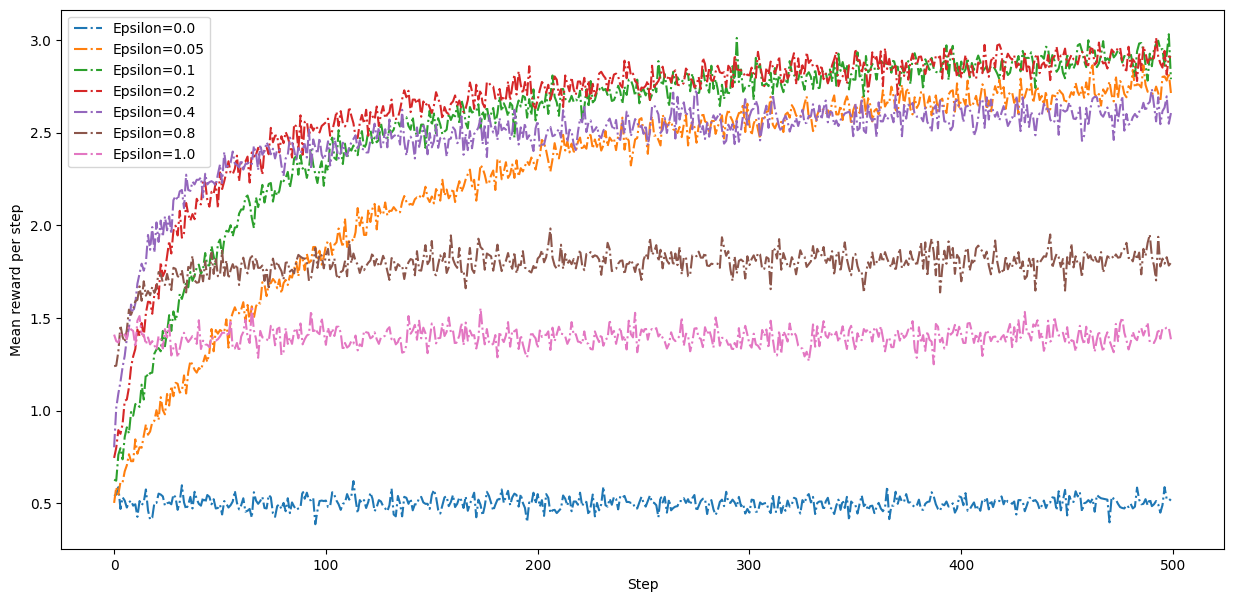

In [ ]:
plt.figure(figsize=(15, 7))

for epsilon in epsilon_to_rewards:

    plt.plot(epsilon_to_rewards[epsilon], '-.', label=f'Epsilon={epsilon}')

plt.xlabel('Step')
plt.ylabel('Mean reward per step')

plt.legend()
plt.show()